### import required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,roc_curve, auc,f1_score
import xgboost as xgb

### Preparing Data

In [2]:
excel_file_path='Breaking Barriers -data.xlsx'

# Load the Excel file
xls = pd.ExcelFile(excel_file_path)

# Get the names of all sheets in the Excel file
sheet_names = xls.sheet_names

# Read the data and separate independent & dependent variables
#Training Data
train_df = pd.read_excel(excel_file_path, sheet_name=sheet_names[0])
X_train=train_df[['Tier', 'Age', 'YrsAdd', 'OldEmi', 'FOIR', 'LTV']]
X_train=X_train.rename(columns={'Tier':'Tier of City',
                                  'OldEmi':'Old EMI amount',
                               'YrsAdd':'Years in Address'})
y_train=train_df['Decision']
print(X_train.shape)

#Validation Data
validation_df=pd.read_excel(excel_file_path, sheet_name=sheet_names[1])
X_valid=validation_df[['Tier', 'Age', 'YrsAdd', 'OldEmi', 'FOIR', 'LTV']]
X_valid=X_valid.rename(columns={'Tier':'Tier of City',
                                'OldEmi':'Old EMI amount',
                               'YrsAdd':'Years in Address' })
y_valid=validation_df['Decision']
print(X_valid.shape)

#Testing Data
test_df = pd.read_excel(excel_file_path, sheet_name=sheet_names[2])
status_mapping = {'Approve': 1, 'Reject': 0}
test_df['Decision'] = test_df['Decision'].map(status_mapping)
X_test=test_df[['Tier of City', 'Age', 'Years in Address', 'Old EMI amount', 'FOIR', 'LTV']]
y_test = test_df['Decision']
print(X_test.shape)

(1570, 6)
(653, 6)
(100, 6)


### Utility function for evaluation metrics

In [3]:
def performance_testing(y_test, y_pred,y_pred_prob):
    # Evaluate accuracy, precision, recall, sensitivity, specificity
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sensitivity = recall  # Sensitivity is the same as recall
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) # Calculate specificity
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## Models

### CART - Entropy

Validation Set Performance:
Accuracy: 0.74
Precision: 0.86
Recall (Sensitivity): 0.82
Specificity: 0.38
F1 Score: 0.84


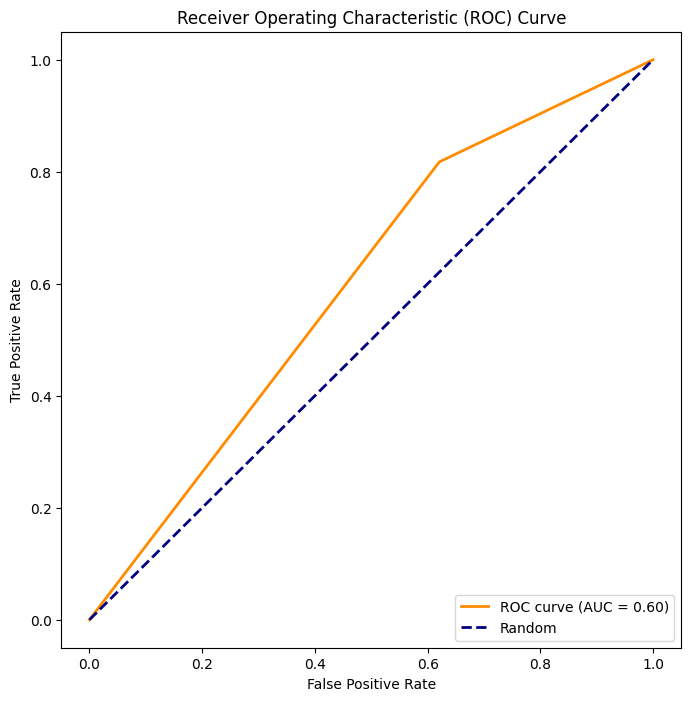


Test Set Performance:
Accuracy: 0.76
Precision: 0.85
Recall (Sensitivity): 0.85
Specificity: 0.33
F1 Score: 0.85


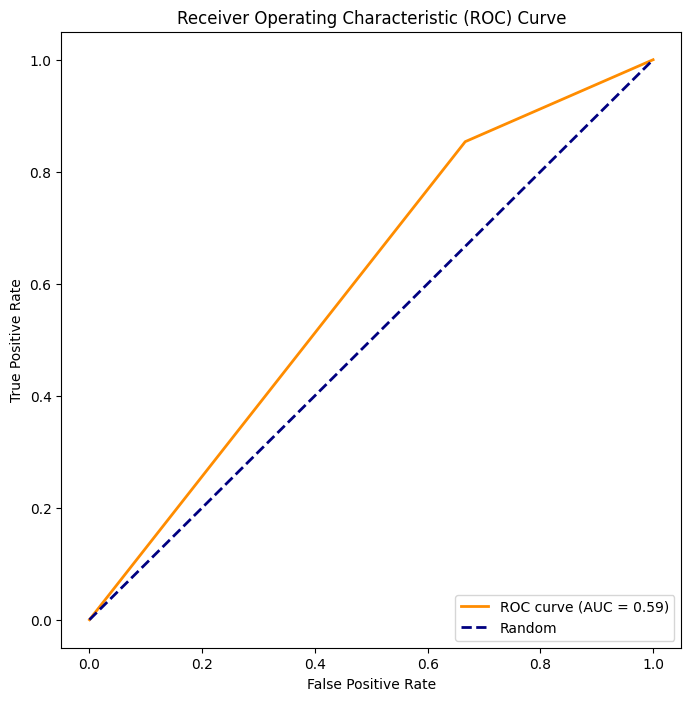

In [4]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

print("Validation Set Performance:")
performance_testing(y_valid, clf.predict(X_valid),clf.predict_proba(X_valid)[:, 1] )

print("\nTest Set Performance:")
performance_testing(y_test, clf.predict(X_test),clf.predict_proba(X_test)[:, 1] )

#### Plot the decision tree


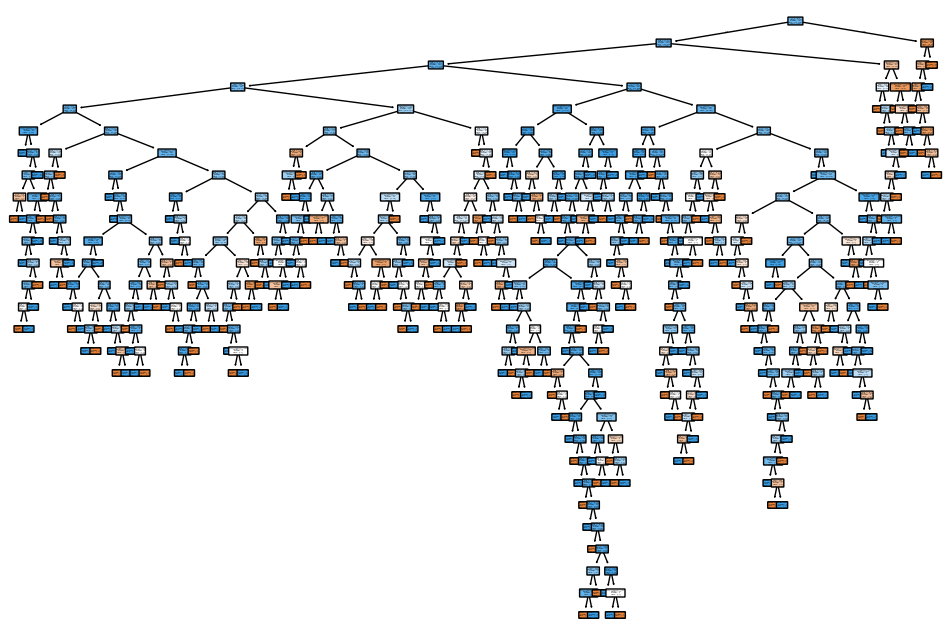

In [5]:
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=list(X_train.columns), class_names=['Reject', 'Accept'], rounded=True)
plt.show()

### CART - Gini

Validation Set Performance:
Accuracy: 0.76
Precision: 0.87
Recall (Sensitivity): 0.84
Specificity: 0.40
F1 Score: 0.85


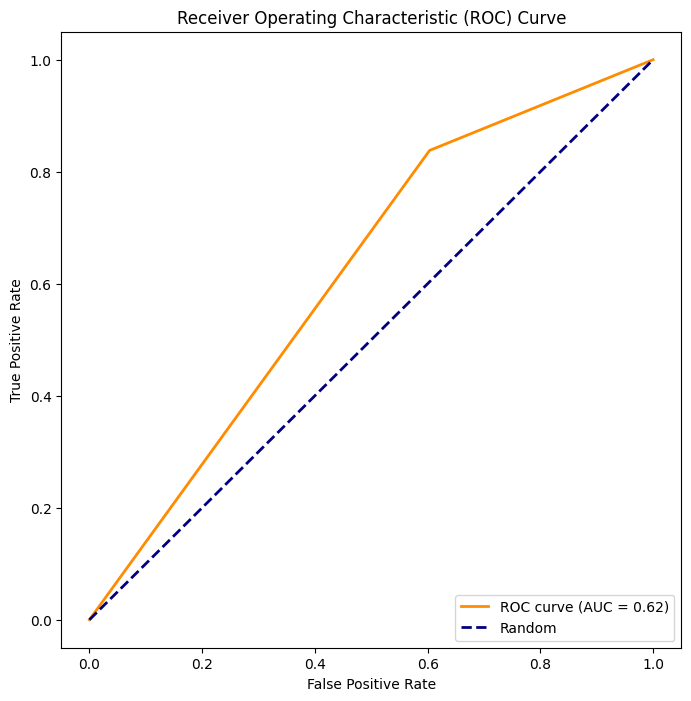


Test Set Performance:
Accuracy: 0.78
Precision: 0.88
Recall (Sensitivity): 0.84
Specificity: 0.50
F1 Score: 0.86


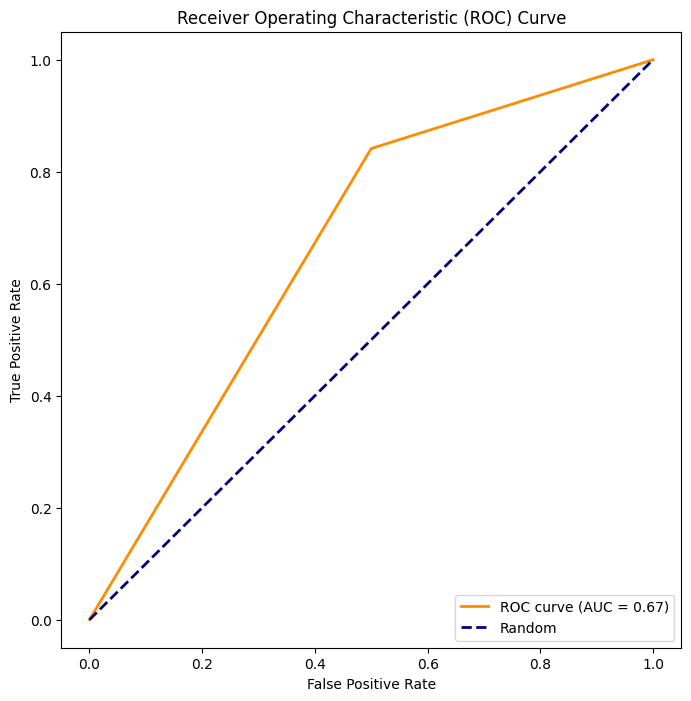

In [6]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='gini', random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

print("Validation Set Performance:")
performance_testing(y_valid, clf.predict(X_valid),clf.predict_proba(X_valid)[:, 1] )

print("\nTest Set Performance:")
performance_testing(y_test, clf.predict(X_test),clf.predict_proba(X_test)[:, 1] )

#### Plot the decision tree


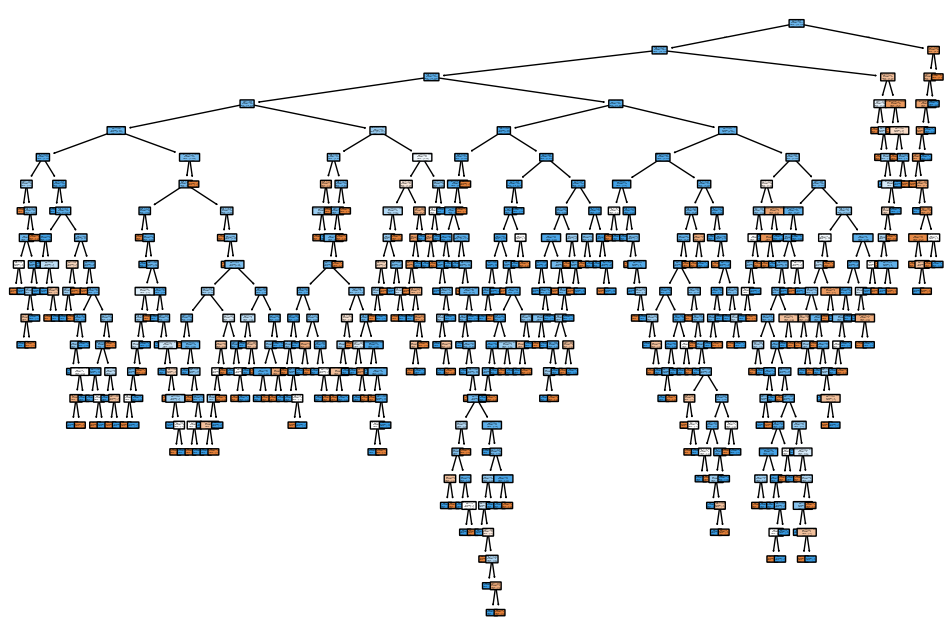

In [7]:
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=list(X_train.columns), class_names=['Reject', 'Accept'], rounded=True)
plt.show()

### Logistic Regression

Validation Set Performance:
Accuracy: 0.83
Precision: 0.83
Recall (Sensitivity): 1.00
Specificity: 0.09
F1 Score: 0.91


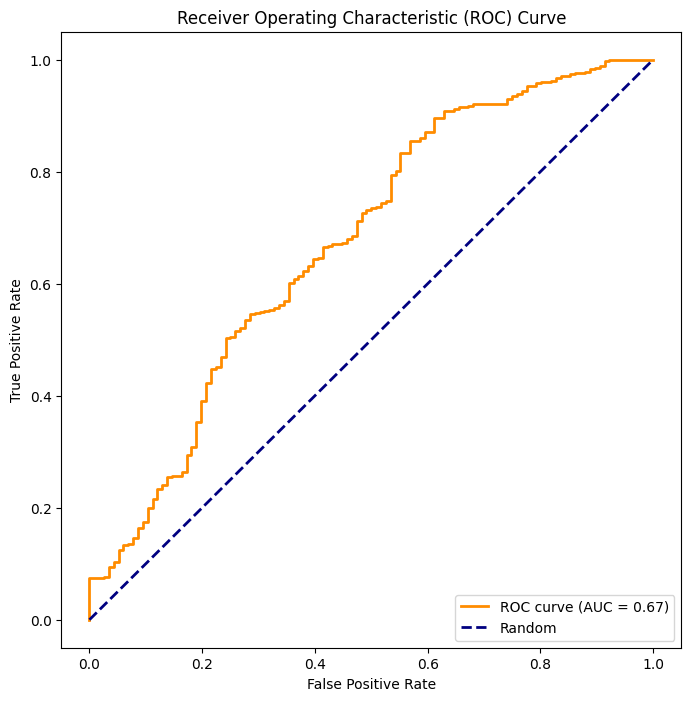


Test Set Performance:
Accuracy: 0.84
Precision: 0.84
Recall (Sensitivity): 0.99
Specificity: 0.17
F1 Score: 0.91


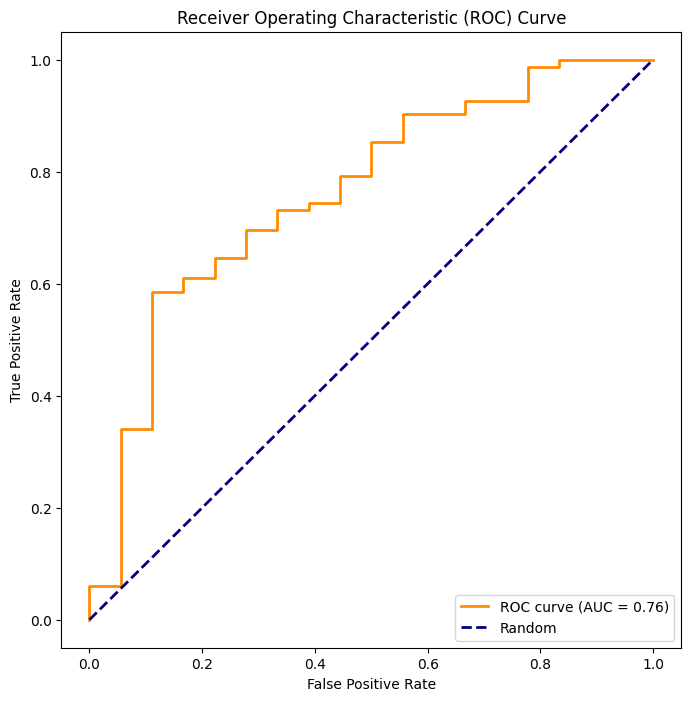

In [8]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
clf_lr = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
clf_lr.fit(X_train, y_train)

# Make predictions on the validation set
y_valid_pred_prob_lr = clf_lr.predict_proba(X_valid)[:, 1]  # Extracting the probability of the positive class

# Print statement before using performance_testing for validation set
print("Validation Set Performance:")
performance_testing(y_valid, clf_lr.predict(X_valid), y_valid_pred_prob_lr)

# Make predictions on the test set
y_test_pred_prob_lr = clf_lr.predict_proba(X_test)[:, 1]  # Extracting the probability of the positive class

# Print statement before using performance_testing for test set
print("\nTest Set Performance:")
performance_testing(y_test, clf_lr.predict(X_test), y_test_pred_prob_lr)

### Random Forest Classifier

Validation Set Performance:
Accuracy: 0.84
Precision: 0.87
Recall (Sensitivity): 0.96
Specificity: 0.33
F1 Score: 0.91


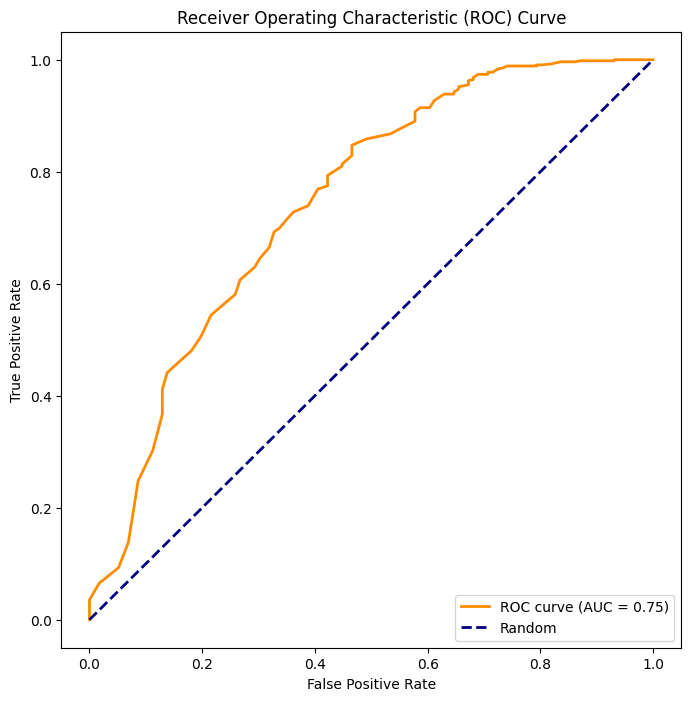


Test Set Performance:
Accuracy: 0.86
Precision: 0.89
Recall (Sensitivity): 0.95
Specificity: 0.44
F1 Score: 0.92


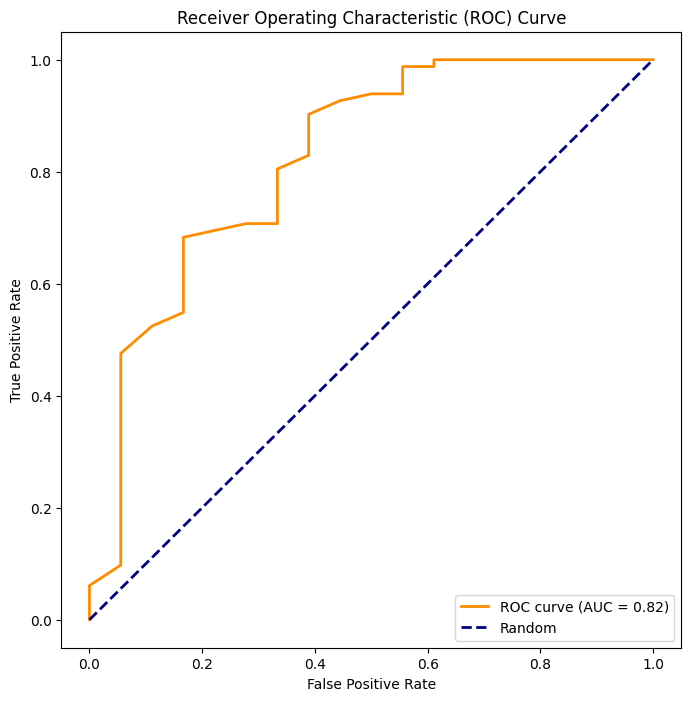

In [9]:
# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(random_state=42)

# Train the model on the training data
clf_rf.fit(X_train, y_train)

# Make predictions on the validation set
y_valid_pred_prob_rf = clf_rf.predict_proba(X_valid)[:, 1]  # Extracting the probability of the positive class

# Print statement before using performance_testing for validation set
print("Validation Set Performance:")
performance_testing(y_valid, clf_rf.predict(X_valid), y_valid_pred_prob_rf)

# Make predictions on the test set
y_test_pred_prob_rf = clf_rf.predict_proba(X_test)[:, 1]  # Extracting the probability of the positive class

# Print statement before using performance_testing for test set
print("\nTest Set Performance:")
performance_testing(y_test, clf_rf.predict(X_test), y_test_pred_prob_rf)

### XGBoost Classifier

Validation Set Performance:
Accuracy: 0.83
Precision: 0.88
Recall (Sensitivity): 0.93
Specificity: 0.40
F1 Score: 0.90


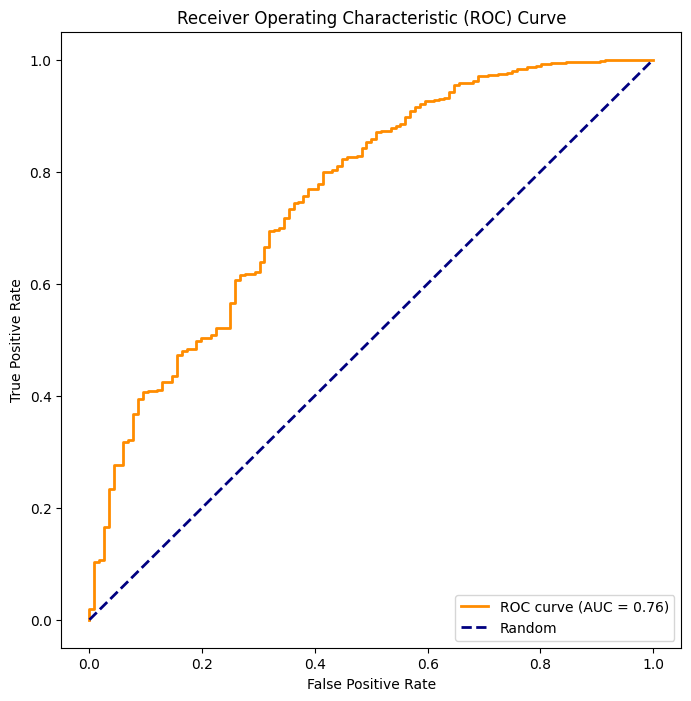


Test Set Performance:
Accuracy: 0.84
Precision: 0.89
Recall (Sensitivity): 0.91
Specificity: 0.50
F1 Score: 0.90


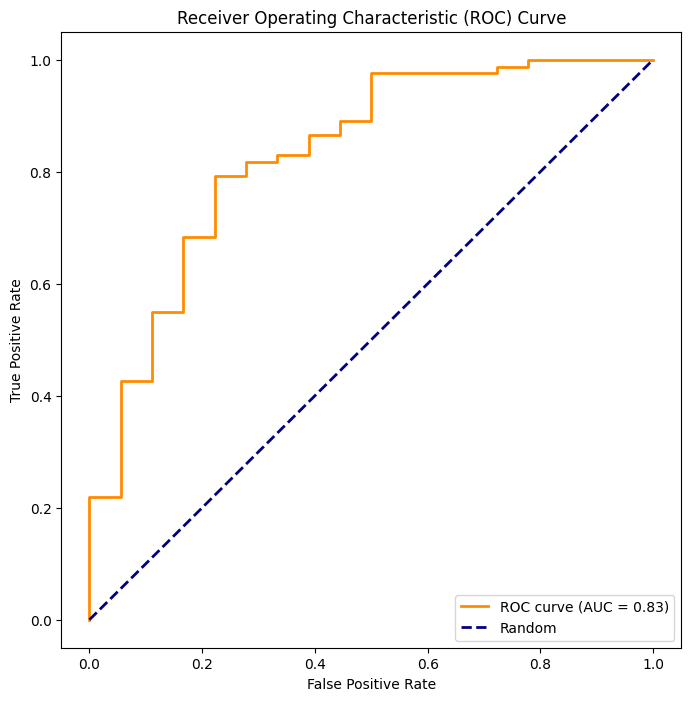

In [10]:
# Initialize the XGBoost Classifier
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model on the training data
clf_xgb.fit(X_train, y_train)

# Make predictions on the validation set
y_valid_pred_prob_xgb = clf_xgb.predict_proba(X_valid)[:, 1]  # Extracting the probability of the positive class

# Print statement before using performance_testing for validation set
print("Validation Set Performance:")
performance_testing(y_valid, clf_xgb.predict(X_valid), y_valid_pred_prob_xgb)

# Make predictions on the test set
y_test_pred_prob_xgb = clf_xgb.predict_proba(X_test)[:, 1]  # Extracting the probability of the positive class

# Print statement before using performance_testing for test set
print("\nTest Set Performance:")
performance_testing(y_test, clf_xgb.predict(X_test), y_test_pred_prob_xgb)